In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from fredapi import Fred
from ta import add_all_ta_features
import pywt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.base import clone
from statsmodels.tsa.stattools import adfuller
from fracdiff.sklearn import FracdiffStat

# Constants
API_KEY = "1e074c3898d6261abc56ff5962358644"
STOCK_TICKER = "AAPL"
MARKET_TICKER = "^GSPC"
START_DATE = "2018-01-02"
END_DATE = "2024-01-01"
SERIES_IDS = {
    "DGS10": "DGS10",
    "VIXCLS": "VIXCLS",
    "CRUDEOILWTI": "DCOILWTICO",
    "DCOILBRENTEU": "DCOILBRENTEU",
    "FFER": "DFF",
    "USDollarIndex": "DTWEXBGS",
}


class DataDownloader:
    def __init__(self, api_key):
        self.fred = Fred(api_key=api_key)

    def safe_api_call(self, call, *args, **kwargs):
        try:
            return call(*args, **kwargs)
        except Exception as e:
            print(f"API call failed: {e}")
            return pd.DataFrame()  # Return empty DataFrame on failure

    def download_fred_series(self, series_id: str) -> pd.Series:
        return self.safe_api_call(self.fred.get_series, series_id)

    def download_and_process_yfinance_data(
        self, ticker: str, start_date: str, end_date: str
    ) -> pd.DataFrame:
        data = self.safe_api_call(yf.download, ticker, start=start_date, end=end_date)
        if not data.empty:
            data.index = pd.DatetimeIndex(
                data.index
            ).normalize()  # Normalize to remove time
            data = data.reindex(
                pd.date_range(start=start_date, end=end_date, freq="B"), method="ffill"
            )
        return data

    def process_macroeconomic_data(
        self, start_date: str, end_date: str
    ) -> pd.DataFrame:
        macro_df = pd.DataFrame(
            index=pd.date_range(start=start_date, end=end_date, freq="B")
        )
        for name, series_id in SERIES_IDS.items():
            series = self.download_fred_series(series_id)
            if not series.empty:
                macro_df[name] = series.reindex(macro_df.index, method="ffill")
        return macro_df


class DataPreprocessor:
    @staticmethod
    def preprocess_data(data: pd.DataFrame) -> pd.DataFrame:
        data = add_all_ta_features(
            data,
            open="Open",
            high="High",
            low="Low",
            close="Close",
            volume="Volume",
            fillna=True,
        )
        data["Target"] = (data["Close"].shift(-1) > data["Close"]).astype(int)
        return data.dropna()

    @staticmethod
    def apply_min_max_normalization(data):
        features = data.drop(["Target"], axis=1)
        scaler = MinMaxScaler()
        normalized_features = scaler.fit_transform(features)
        normalized_columns = [f"{col}_Norm" for col in features.columns]
        normalized_df = pd.DataFrame(
            normalized_features, columns=normalized_columns, index=data.index
        )
        data_normalized = pd.concat([data, normalized_df], axis=1)
        return data_normalized

    @staticmethod
    def apply_fractional_differencing(
        df: pd.DataFrame, threshold: float = 0.05
    ) -> pd.DataFrame:
        f_diff = FracdiffStat()
        for column in df.columns.difference(["Target"]):
            p_value = adfuller(df[column])[1]
            if p_value > threshold:
                transformed_column = f_diff.fit_transform(df[[column]])
                df[column + "_fdiff"] = transformed_column.squeeze()
        return df

    @staticmethod
    def haar_wavelet_denoising(series, level=1):
        coeffs = pywt.wavedec(series, "haar", level=level)
        coeffs[1:] = (
            pywt.threshold(i, value=0.5 * np.max(i), mode="soft") for i in coeffs[1:]
        )
        denoised_series = pywt.waverec(coeffs, "haar")
        if len(denoised_series) > len(series):
            denoised_series = denoised_series[: len(series)]
        elif len(denoised_series) < len(series):
            denoised_series = np.pad(
                denoised_series, (0, len(series) - len(denoised_series)), "edge"
            )
        return denoised_series

    @staticmethod
    def apply_haar_denoising(data):
        denoised_columns = ["Open", "High", "Low", "Close", "Volume"]
        for column in denoised_columns:
            denoised_series = DataPreprocessor.haar_wavelet_denoising(
                data[column].values
            )
            data[f"{column}_Denoised"] = denoised_series
        return data


class ModelTrainer:
    def __init__(self, n_splits=5):
        self.n_splits = n_splits

    def time_series_cross_validation(self, X, y):
        tscv = TimeSeriesSplit(n_splits=self.n_splits)
        mean_scores = []

        for n_features in range(1, X.shape[1] + 1):
            scores = []
            for train_index, test_index in tscv.split(X):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)

                rfe = RFE(estimator=LogisticRegression(max_iter=1000, random_state=42),
                          n_features_to_select=n_features)
                rfe.fit(X_train_scaled, y_train)

                X_train_selected = X_train_scaled[:, rfe.support_]
                X_test_selected = X_test_scaled[:, rfe.support_]

                model = LogisticRegression(max_iter=1000, random_state=42)
                model.fit(X_train_selected, y_train)

                y_pred = model.predict(X_test_selected)
                scores.append(accuracy_score(y_test, y_pred))

            mean_scores.append(np.mean(scores))

        plt.plot(range(1, X.shape[1] + 1), mean_scores)
        plt.xlabel("Number of Features")
        plt.ylabel("Mean Accuracy")
        plt.show()

        return np.argmax(mean_scores) + 1



def calculate_trading_performance(stock_prices, predictions):
    returns = stock_prices.pct_change().shift(-1)[:-1]  # Calculate returns for the investment period
    strategy_returns = returns * predictions[:-1]  # Apply predictions to returns; align lengths

    cumulative_return = (strategy_returns + 1).cumprod().iloc[-1] - 1
    negative_returns = strategy_returns[strategy_returns < 0]
    downside_deviation = np.sqrt(np.mean(negative_returns ** 2))

    target_return = 0
    sortino_ratio = (strategy_returns.mean() - target_return) / downside_deviation if downside_deviation else 0

    print(f"Cumulative Return: {cumulative_return}, Downside Deviation: {downside_deviation}, Sortino Ratio: {sortino_ratio}")
    plt.title('cumulative_return')
    plt.plot((strategy_daily_returns+1).cumprod())
    plt.plot((actuals_daily_returns+1).cumprod())
    plt.legend(['prediction', 'buy&hold'], loc='lower right')



    return cumulative_return, downside_deviation, sortino_ratio



downloader = DataDownloader(API_KEY)
preprocessor = DataPreprocessor()
trainer = ModelTrainer()

stock_data = downloader.download_and_process_yfinance_data(
    STOCK_TICKER, START_DATE, END_DATE
)
market_data = downloader.download_and_process_yfinance_data(
    MARKET_TICKER, START_DATE, END_DATE
)
macro_data = downloader.process_macroeconomic_data(START_DATE, END_DATE)

additional_data = {
    "GoldPrices": downloader.download_and_process_yfinance_data(
        "GC=F", START_DATE, END_DATE
    ),
    "OilPrices": downloader.download_and_process_yfinance_data(
        "CL=F", START_DATE, END_DATE
    ),
}

combined_data = stock_data.join(
    market_data[["Close"]].rename(columns={"Close": "MarketClose"}), how="left"
).fillna(method="ffill")
combined_data = combined_data.join(macro_data, how="left").fillna(method="ffill")
for name, data in additional_data.items():
    combined_data = combined_data.join(
        data[["Close"]].rename(columns={"Close": f"{name}Close"}), how="left"
    ).fillna(method="ffill")

combined_data_denoised = preprocessor.apply_haar_denoising(combined_data)
preprocessed_data = preprocessor.preprocess_data(combined_data_denoised)
final_dataset = preprocessor.apply_fractional_differencing(preprocessed_data)
final_dataset_normalized = preprocessor.apply_min_max_normalization(final_dataset)

c:\Users\markm\miniconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
c:\Users\markm\miniconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
c:\Users\markm\miniconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
def train_and_evaluate_model(X_train, y_train, X_test, y_test, estimator, n_features_to_select):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    rfe = RFE(estimator=estimator, n_features_to_select=n_features_to_select)
    rfe.fit(X_train_scaled, y_train)

    # Extracting optimal feature names
    feature_names = X_train.columns[rfe.support_]

    X_train_selected = X_train_scaled[:, rfe.support_]
    X_test_selected = X_test_scaled[:, rfe.support_]

    model = clone(estimator)
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)

    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Optimal features: {feature_names}")
    print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
    print(f"Confusion Matrix:\n{conf_matrix}")

    return model, feature_names, y_pred

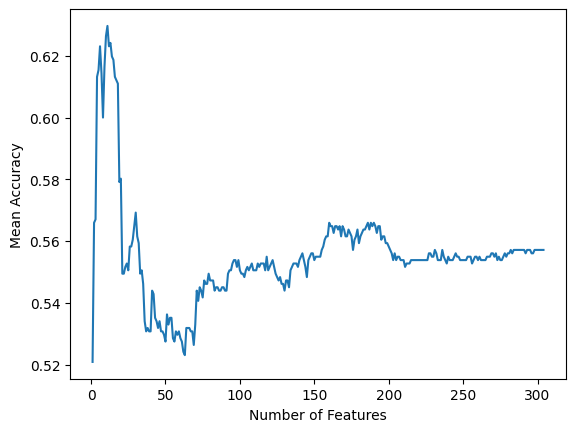

Optimal number of features: 11


In [6]:
X = final_dataset_normalized.drop("Target", axis=1)
y = final_dataset_normalized["Target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=False
)

optimal_n_features = trainer.time_series_cross_validation(X_train, y_train)
print(f"Optimal number of features: {optimal_n_features}")

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_trading_performance_plot(stock_prices, predictions):
    returns = stock_prices.pct_change().shift(-1)[:-1]  # Calculate returns for the investment period
    strategy_returns = returns * predictions[:-1]  # Apply predictions to returns; align lengths

    cumulative_return = (strategy_returns + 1).cumprod().iloc[-1] - 1
    negative_returns = strategy_returns[strategy_returns < 0]
    downside_deviation = np.sqrt(np.mean(negative_returns ** 2))

    target_return = 0
    sortino_ratio = (strategy_returns.mean() - target_return) / downside_deviation if downside_deviation else 0

    print(f"Cumulative Return: {cumulative_return}, Downside Deviation: {downside_deviation}, Sortino Ratio: {sortino_ratio}")
    plt.title('Cumulative Return')
    plt.plot((strategy_returns+1).cumprod())
    plt.plot((returns+1).cumprod())
    plt.legend(['Prediction', 'Buy & Hold'], loc='lower right')

    return cumulative_return, downside_deviation, sortino_ratio

Optimal features: Index(['Close_Denoised', 'volatility_bbh', 'Close_Denoised_fdiff',
       'Open_Denoised_fdiff', 'trend_ema_fast_fdiff', 'Close_Denoised_Norm',
       'volatility_bbh_Norm', 'Close_Denoised_fdiff_Norm',
       'High_Denoised_fdiff_Norm', 'Open_Denoised_fdiff_Norm',
       'others_cr_fdiff_Norm'],
      dtype='object')
Accuracy: 0.6425531914893617, Precision: 0.6620370370370371, Recall: 0.6008403361344538, F1 Score: 0.6299559471365639
Confusion Matrix:
[[159  73]
 [ 95 143]]
Cumulative Return: 2.9406200308218615, Downside Deviation: 0.016103021741935807, Sortino Ratio: 0.18644075458225048


(2.9406200308218615, 0.016103021741935807, 0.18644075458225048)

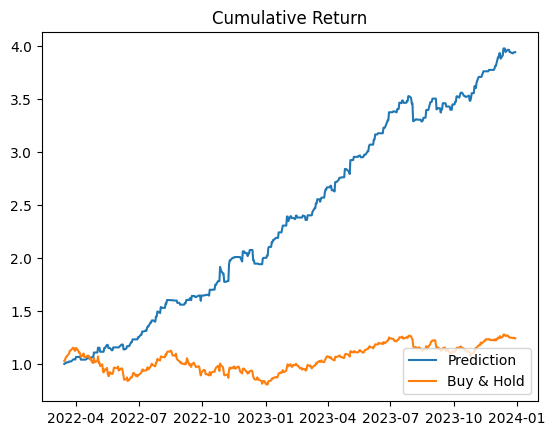

In [19]:
estimator = LogisticRegression(max_iter=1000, random_state=42)

model, feature_names, y_pred = train_and_evaluate_model(X_train, y_train, X_test, y_test, estimator, optimal_n_features)

stock_prices_test = stock_data.loc[X_test.index, 'Close']

calculate_trading_performance_plot(stock_prices_test, y_pred)